# BOOK RECOMMENDER

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

from IPython.display import Markdown, display 

import pickle

In [2]:
gr_data = pd.read_csv('./2. Clean_df/gr_data_CLEAN.csv')
gr_data = gr_data.drop(['Unnamed: 0'],axis=1)

In [3]:
gr_data.shape

(48655, 862)

In [4]:
# Check categorical columns
categorical = gr_data.select_dtypes(include=['object'])
categorical.columns

Index(['title', 'series', 'author', 'description', 'language', 'pages', 'isbn',
       'book_format', 'publisher'],
      dtype='object')

#### Recovering numerical values of 'pages' from original dataframe

In [5]:
original_df = pd.read_csv('./1. Original_df/GoodReads.Best_Books_Ever 2.csv')
original_df['pages']

0        374
1        870
2        324
3        279
4        501
        ... 
52473      0
52474    190
52475    280
52476    507
52477    201
Name: pages, Length: 52478, dtype: object

In [6]:
# Adding column with numerical pages where 'title' matches (gr_data is shorter and no NaN)
gr_data['pages2'] = ''

for index, row in original_df.iterrows():
    title = row['title']
    pages = row['pages']
    gr_data.loc[gr_data['title'] == title, 'pages2'] = pages
#gr_data = pd.merge(gr_data, original_df[['title', 'pages']], on='title', how='left')
#merged_df.drop('title', axis=1, inplace=True)
#gr_data.rename(columns={'pages': 'pages2'}, inplace=True)

In [7]:
# Same length
len(gr_data['pages2'])

48655

In [15]:
# NaN
gr_data['pages2'].isna().sum()

114

In [16]:
# Delete rows with NaN
gr_data.dropna(subset=['pages2'], inplace=True)

In [17]:
# Type
gr_data['pages2'].dtype

dtype('O')

In [19]:
# Deleting row with str
gr_data = gr_data.drop(gr_data[gr_data['pages2'] == '1 page'].index)

# Converting to numerical
gr_data['pages2'] = gr_data['pages2'].astype(np.number)

In [21]:
gr_data['pages2'].dtype

dtype('float64')

### Clustering features with K-Means

#### Features (numerical data)

In [22]:
features = gr_data.select_dtypes(include=np.number)
features.shape

(48540, 854)

In [25]:
X = features

#### Scaling data (without training)

In [26]:
#from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_prep = scaler.transform(X)

pd.DataFrame(X_prep,columns=X.columns).head()

,publish_year,first_publish_year,liked_perc,bbe_score,bbe_votes,log_num_ratings,5_stars_num_ratings,4_stars_num_ratings,3_stars_num_ratings,2_stars_num_ratings,...,West Australian Young Readers' Book Award (WAYRBA) for Younger Readers,William Allen White Children's Book Award,William C. Morris YA Debut Award Nominee,Women's Prize for Fiction Nominee,Women's Prize for Fiction Nominee for Longlist,World Fantasy Award Nominee for Best Novel,World Fantasy Award for Best Novel,Zilveren Griffel,الجائزة العالمية للرواية العربية (أي باف) / International Prize for Arabic Fiction (IPAF) Nominee,pages2
0,0.207263,0.177221,0.438259,7.941488,8.357558,3.282082,65.257891,58.372793,42.150463,29.525275,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,0.185473
1,-0.164730,-0.084770,0.627352,7.838949,8.249685,2.905250,30.111531,19.239087,12.436311,6.665401,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,2.215428
2,0.021267,-2.337885,0.343712,7.720796,8.126263,3.141437,44.736517,40.444039,32.378957,25.720158,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.019160
3,-0.536723,0.439211,0.249166,7.613373,8.012962,2.977397,30.565800,24.699864,21.014602,19.502361,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.203329
4,0.021267,0.020027,-1.263581,7.369117,7.738725,3.181004,33.108057,33.753952,57.123332,93.402448,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.428425


#### Choosing k (defining best number of clusters) // Elbow and Silhouette

- Elbow method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

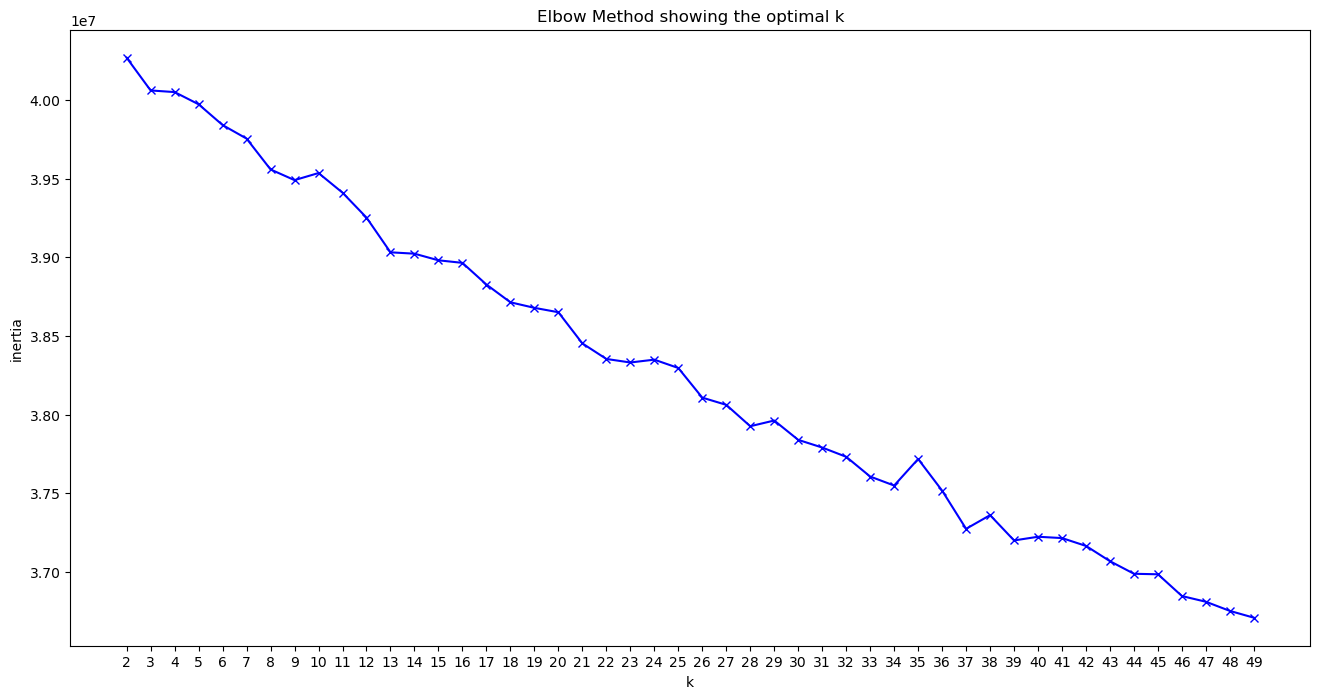

In [34]:
# Setting large range of clusters
K = range(2, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Elbow line trend is quite irregular, but seems that 3, 9 or 13 k.

- Silohuette method

In [55]:
%env OPENBLAS_NUM_THREADS=1

env: OPENBLAS_NUM_THREADS=1


In [56]:
export OPENBLAS_NUM_THREADS=1

SyntaxError: invalid syntax (996608145.py, line 1)

In [ ]:
#from sklearn.metrics import silhouette_score

#K = range(2, 50)
#silhouette = []

#for k in K:
#    kmeans = KMeans(n_clusters=k, random_state=1234)
#    kmeans.fit(X_prep)
#    #silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))
#    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep), n_jobs=1))



#plt.figure(figsize=(16,8))
#plt.plot(K, silhouette, 'bx-')
#plt.xlabel('k')
#plt.ylabel('silhouette score')
#plt.xticks(np.arange(min(K), max(K)+1, 1.0))
#plt.title('Silhouette score showing the optimal k')

In [60]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K is the range of clusters you want to test
K = range(2, 60)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    labels = kmeans.fit_predict(X_prep)
    score = silhouette_score(X_prep, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


KeyboardInterrupt: 

#### Checking Means with N and M cluters

In [ ]:
#3,9,13

In [49]:
kmeans = KMeans(n_clusters=13, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=13, random_state=1234)

In [51]:
print("Shape of X_prep:", X_prep.shape)
print("Shape of cluster centers:", kmeans.cluster_centers_.shape)

Shape of X_prep: (48540, 854)
Shape of cluster centers: (13, 854)


In [48]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

AttributeError: 'NoneType' object has no attribute 'split'

In [47]:
# Size of the clusters / Number of songs in each cluster
pd.Series(clusters).value_counts().sort_index()

NameError: name 'clusters' is not defined

In [ ]:
clusters

In [ ]:
#y.values
#pd.Series(y).value_counts().sort_index()

In [ ]:
# Plotting (num clusters = 2)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 2], c=clusters,alpha=0.5)

plt.show()